This notebook was created at 23:53 18/10/20

Liquid crystal phase classification using deep learning techniques

First attempt to classify liquid crystal phases using the dataset shared by Josh Heaton.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.experimental.preprocessing import Rescaling, RandomFlip
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing import image_dataset_from_directory
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import tensorflow as tf

Load in the data.

In [2]:
train_directory = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images_from_drive/Training"
test_directory = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images_from_drive/Validation"
image_size = (200,200)

# Change images to grayscale as colour isnt an important feature at this stage
train_dataset = image_dataset_from_directory(train_directory,
                            labels="inferred",
                            label_mode="categorical",
                            color_mode="grayscale",
                            batch_size=64,
                            image_size=image_size,
                            shuffle=True
                        )
val_dataset = image_dataset_from_directory(test_directory,
                            labels="inferred",
                            label_mode="categorical",
                            color_mode="grayscale",
                            batch_size=64,
                            image_size=image_size,
                            shuffle=True
                        )

Found 1914 files belonging to 5 classes.
Found 313 files belonging to 5 classes.


Let's see if the files imported as expected.

In [3]:
print(train_dataset.element_spec)
print(train_dataset.class_names)
for data, labels in train_dataset:
    print(data.shape)
    print(data.dtype)
    print(labels.shape)
    print(labels.dtype)

(TensorSpec(shape=(None, 200, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))
['Cholesteric', 'Columnar', 'Nematic', 'Smectic', 'Twist_grain_boundary']
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'floa

In [4]:
print(val_dataset.element_spec)
print(val_dataset.class_names)
for data, labels in val_dataset:
    print(data.shape)
    print(data.dtype)
    print(labels.shape)
    print(labels.dtype)

(TensorSpec(shape=(None, 200, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))
['Cholesteric', 'Columnar', 'Nematic', 'Smectic', 'Twist_grain_boundary']
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(57, 200, 200, 1)
<dtype: 'float32'>
(57, 5)
<dtype: 'float32'>


Let's define a function to plot a graph to see how our model works over iterations. (From Josh Heaton)

In [5]:
def plot_loss_acc_history(history):
    fig, axis = plt.subplots(2)
    #fig.subtitle('Training losses and accuracies')
    
    axis[0].plot(history.history['loss'], label='loss')
    axis[0].plot(history.history['val_loss'], label='val_loss')
    axis[0].set_xlabel('Epoch')
    axis[0].set_ylabel('Loss')
    axis[0].legend(loc='upper right')
    
    axis[1].plot(history.history['accuracy'], label='accuracy')
    axis[1].plot(history.history['val_accuracy'], label='val_accuracy')
    axis[1].set_xlabel('Epoch')
    axis[1].set_ylabel('Accuracy')
    axis[1].legend(loc='upper right')

    plt.show()

Let's define our pipeline.

In [12]:
image_shape = (image_size[0], image_size[1], 1)
X_inputs = Input(shape = image_shape)
# Rescale images to have values in range [0,1]
X = Rescaling(scale = 1/255)(X_inputs)
X = RandomFlip()(X)

# Apply convolutional and pooling layers
X = Conv2D(filters=32, kernel_size=(3,3))(X)
X = BatchNormalization()(X)
X = Activation("relu")(X)
X = MaxPooling2D(pool_size=(3,3))(X)
X = Conv2D(filters=64, kernel_size=(3,3))(X)
X = BatchNormalization()(X)
X = Activation("relu")(X)
X = MaxPooling2D(pool_size=(3,3))(X)
X = Conv2D(filters=128, kernel_size=(3,3))(X)
X = BatchNormalization()(X)
X = Activation("relu")(X)
X = MaxPooling2D(pool_size=(3,3))(X)

# Apply fully connected layer
X = Flatten()(X)
X = Dense(units=128, activation="relu")(X)
X = Dropout(0.3)(X)
X = Dense(units=64, activation="relu")(X)
X = Dropout(0.3)(X)
# Output layer
num_classes = 5
X_outputs = Dense(units=num_classes, activation="softmax")(X)

model = Model(inputs = X_inputs, outputs = X_outputs)

Let's see what this model looks like.

In [13]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 200, 200, 1)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 198, 198, 32)      128       
_________________________________________________________________
activation_3 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 66, 66, 32)       

Now we need to compile, train and test the model.

In [14]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
directory = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)"
checkpoint = ModelCheckpoint(directory, monitor = "val_accuracy", save_best_only = True, mode="max")

history = model.fit(x=train_dataset, epochs=100, verbose=2, callbacks=[checkpoint], validation_data=val_dataset)

Epoch 1/100
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/Jason/Documents/University/Year_4\MPhys_Project(s)\assets
30/30 - 88s - loss: 1.6461 - accuracy: 0.4765 - val_loss: 1.5982 - val_accuracy: 0.3099
Epoch 2/100
30/30 - 86s - loss: 0.7687 - accuracy: 0.7409 - val_loss: 1.9240 - val_accuracy: 0.3099
Epoch 3/100
30/30 - 86s - loss: 0.5118 - accuracy: 0.8192 - val_loss: 2.8238 - val_accuracy: 0.3099
Epoch 4/100
30/30 - 87s - loss: 0.4215 - accuracy: 0.8485 - val_loss: 4.0034 - val_accuracy: 0.3099
Epoch 5/100
30/30 - 86s - loss: 0.2942 - accuracy: 0.9013 - val_loss: 3.7424 - val_accuracy: 0.3099
Epoch 6/100
30/30 - 85s - loss: 0.2847 - accuracy: 0.9060 - val_loss: 4.9663 - val_accuracy: 0.3099
Epoch 7/100
30/30 - 86s - loss: 0.1885 - accuracy: 0.9347 - val_

30/30 - 83s - loss: 0.0342 - accuracy: 0.9911 - val_loss: 1.3844 - val_accuracy: 0.6454
Epoch 69/100
30/30 - 83s - loss: 0.0200 - accuracy: 0.9937 - val_loss: 0.9877 - val_accuracy: 0.8498
Epoch 70/100
30/30 - 83s - loss: 0.0135 - accuracy: 0.9958 - val_loss: 0.8715 - val_accuracy: 0.8818
Epoch 71/100
30/30 - 83s - loss: 0.0146 - accuracy: 0.9948 - val_loss: 1.6166 - val_accuracy: 0.7252
Epoch 72/100
30/30 - 83s - loss: 0.0090 - accuracy: 0.9990 - val_loss: 0.6047 - val_accuracy: 0.8978
Epoch 73/100
30/30 - 83s - loss: 0.0141 - accuracy: 0.9958 - val_loss: 13.8111 - val_accuracy: 0.1949
Epoch 74/100
30/30 - 84s - loss: 0.0087 - accuracy: 0.9963 - val_loss: 10.8895 - val_accuracy: 0.2204
Epoch 75/100
30/30 - 83s - loss: 0.0055 - accuracy: 0.9990 - val_loss: 6.4790 - val_accuracy: 0.5591
Epoch 76/100
30/30 - 82s - loss: 0.0093 - accuracy: 0.9963 - val_loss: 4.0568 - val_accuracy: 0.6038
Epoch 77/100
30/30 - 83s - loss: 0.0364 - accuracy: 0.9943 - val_loss: 31.1037 - val_accuracy: 0.4345


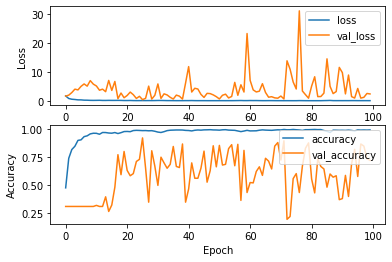

In [17]:
plot_loss_acc_history(history)

We want to now load in the trained model that was saved at its best point (best meaning highest validation accuracy)

In [20]:
model_filepath = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)"
trained_model = tf.keras.models.load_model(model_filepath)

In [21]:
trained_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 200, 200, 1)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 198, 198, 32)      128       
_________________________________________________________________
activation_3 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 66, 66, 32)       

Let's get in our validation data but with a seed so we can compare to predictions consistently

In [69]:
test_directory = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images_from_drive/Validation"
image_size = (200,200)
new_val_dataset = image_dataset_from_directory(test_directory,
                            labels="inferred",
                            label_mode="categorical",
                            color_mode="grayscale",
                            batch_size=64,
                            image_size=image_size,
                        )

Found 313 files belonging to 5 classes.


In [70]:
print(new_val_dataset.element_spec)
print(new_val_dataset.class_names)
for data, labels in new_val_dataset:
    print(data.shape)
    print(data.dtype)
    print(labels.shape)
    print(labels.dtype)

(TensorSpec(shape=(None, 200, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))
['Cholesteric', 'Columnar', 'Nematic', 'Smectic', 'Twist_grain_boundary']
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(64, 200, 200, 1)
<dtype: 'float32'>
(64, 5)
<dtype: 'float32'>
(57, 200, 200, 1)
<dtype: 'float32'>
(57, 5)
<dtype: 'float32'>


In [71]:
trained_model.evaluate(new_val_dataset, verbose=2)

5/5 - 1s - loss: 0.3728 - accuracy: 0.9233


[0.3727888762950897, 0.9233226776123047]

In [72]:
val_predictions = trained_model.predict(new_val_dataset)

[3 0 2 2 0 2 4 3 0 0 3 0 2 0 1 0 2 2 2 1 3 0 2 2 2 2 4 4 2 0 3 2 2 3 0 2 2
 4 2 0 4 3 2 4 0 3 0 0 2 3 0 0 0 0 0 0 0 2 2 2 0 0 4 2 0 3 0 4 2 0 2 0 2 0
 0 2 2 0 2 4 0 0 4 0 0 4 2 1 4 2 0 0 3 0 0 1 2 0 0 4 4 2 2 0 3 2 3 4 3 4 1
 3 0 2 0 0 2 3 2 4 2 0 3 0 1 2 0 0 4 3 4 3 2 2 2 3 0 0 3 0 1 3 0 0 2 0 1 1
 2 2 0 1 3 2 1 0 3 2 0 2 3 0 2 4 0 3 1 2 0 4 2 1 2 4 0 0 3 3 4 2 4 0 0 2 3
 2 0 0 2 2 2 3 2 2 3 2 2 3 0 0 3 3 2 0 2 3 0 2 2 0 2 2 1 2 4 2 3 0 3 2 3 0
 2 0 2 1 0 4 2 0 0 0 4 1 0 0 3 2 0 3 1 0 3 3 0 2 2 0 0 2 0 0 0 2 0 0 0 0 3
 2 2 1 0 3 3 1 3 0 2 2 1 0 0 0 1 3 3 4 0 0 0 2 3 1 2 0 2 2 0 2 2 2 2 2 0 0
 3 0 2 0 4 3 2 3 2 3 4 2 0 1 4 4 3]
[0 3 1 0 2 4 2 2 3 0 3 2 0 0 2 2 4 2 2 0 0 3 3 0 3 0 2 0 2 2 0 0 4 0 3 0 2
 3 0 2 3 0 2 2 3 2 2 0 2 0 2 2 0 2 0 1 2 0 2 0 4 2 0 2 0 4 2 0 2 2 2 0 3 2
 2 2 4 2 2 0 0 4 0 0 0 2 3 0 2 0 0 2 0 3 0 4 2 3 0 1 2 3 3 0 2 0 2 4 0 0 2
 0 3 0 0 2 3 3 0 0 2 2 2 0 4 2 4 3 0 0 0 4 0 2 0 2 3 2 2 4 3 0 0 1 0 4 2 3
 2 0 3 0 1 2 3 0 2 3 2 0 0 0 0 2 4 2 0 4 0 2 2 3 2 2 0 0 0 1 0 0

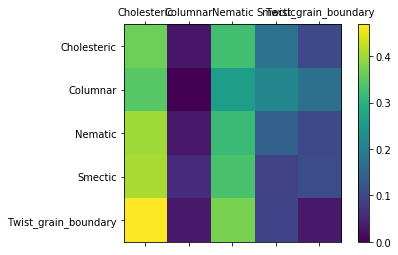

In [75]:
# Get true labels
y_true = np.argmax(np.concatenate([labels for data, labels in new_val_dataset], axis=0), axis=1)
y_pred = np.argmax(val_predictions, axis = 1)

print(y_true)
print(y_pred)

print("Confusion matrix:")
phases = ['Cholesteric', 'Columnar', 'Nematic', 'Smectic', 'Twist_grain_boundary']
  
figure = plt.figure() 
axes = figure.add_subplot(111) 
 
caxes = axes.matshow(confusion_matrix(y_true=y_true, y_pred=y_pred, normalize="true"), interpolation ='nearest') 
figure.colorbar(caxes) 
  
axes.set_xticklabels(['']+phases) 
axes.set_yticklabels(['']+phases) 
  
plt.show() 

Now let's get some test images in to see some predictions

In [36]:
test_image_directory = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images_from_drive/Test_images_Ingo_book"
image_size = (200,200)
test_image_dataset = image_dataset_from_directory(test_image_directory,
                            labels="inferred",
                            label_mode="categorical",
                            color_mode="grayscale",
                            batch_size=64,
                            image_size=image_size,
                        )

Found 26 files belonging to 5 classes.


In [38]:
print(test_image_dataset.element_spec)
print(test_image_dataset.class_names)
for data, labels in test_image_dataset:
    print(data.shape)
    print(data.dtype)
    print(labels.shape)
    print(labels.dtype)

(TensorSpec(shape=(None, 200, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))
['Cholesteric', 'Columnar', 'Nematic', 'Smectic', 'Twist_grain_boundary']
(26, 200, 200, 1)
<dtype: 'float32'>
(26, 5)
<dtype: 'float32'>


In [51]:
predictions = trained_model.predict(test_image_dataset)

In [53]:
test_accuracy = trained_model.evaluate(test_image_dataset, verbose=2)

1/1 - 0s - loss: 4.6584 - accuracy: 0.3077


[0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4]
[4 0 0 4 1 0 0 0 2 0 2 2 2 0 0 0 2 0 2 0 0 2 1 1 2 2]
Confusion matrix:


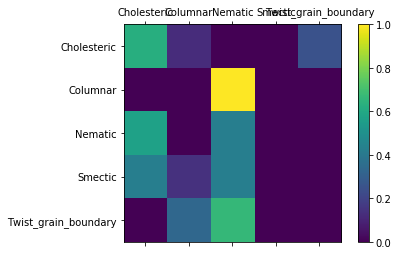

In [52]:
# Get true labels
y_true = np.argmax(np.concatenate([labels for data, labels in test_image_dataset], axis=0), axis=1)
y_pred = np.argmax(predictions, axis = 1)

print(y_true)
print(y_pred)

print("Confusion matrix:")
phases = ['Cholesteric', 'Columnar', 'Nematic', 'Smectic', 'Twist_grain_boundary']
  
figure = plt.figure() 
axes = figure.add_subplot(111) 
 
caxes = axes.matshow(confusion_matrix(y_true=y_true, y_pred=y_pred, normalize="true"), interpolation ='nearest') 
figure.colorbar(caxes) 
  
axes.set_xticklabels(['']+phases) 
axes.set_yticklabels(['']+phases) 
  
plt.show() 

I think from the confusion matrices, we're being misled into thinking this is a good generalisable model. The model is suffering due to the imbalanced dataset - too many cholesteric and nematic compared to other.